In [1]:
# import standard python libraries
import os
from datetime import datetime
import numpy as np
import pandas as pd


# import the PyTorch deep learning libary
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from torch.utils import data

# import sklearn classification evaluation library
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

# import matplotlib, seaborn, and PIL data visualization libary
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# import tensorflow
import tensorflow as tf
import timeit

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
%matplotlib inline

In [0]:
if not os.path.exists('./data'): os.makedirs('./data')  # create data directory
if not os.path.exists('./models'): os.makedirs('./models')  # create trained models directory

#Data Preperation

In [0]:
# download the Fashion MNIST training data
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)

# download the Fashion MNIST evaluation data
eval_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True)

In [0]:
train_images = train_dataset.data.numpy().reshape(-1,28*28)
train_labels = train_dataset.targets.data.numpy()

In [6]:
type(train_labels[1])

numpy.int64

In [0]:
# pd.DataFrame(train_images).to_csv("./data/FashionMNIST/processed/train_images.csv",header=None, index=None)
# pd.DataFrame(train_labels).to_csv("./data/FashionMNIST/processed/train_labels.csv",header=None, index=None)

In [0]:
tensor_train_images = torch.Tensor(train_images)
tensor_train_labels = torch.Tensor(train_labels)

reshaped_train_dataset = data.TensorDataset(tensor_train_images, tensor_train_labels)

In [0]:
eval_images = eval_dataset.data.numpy().reshape(-1,28*28)
eval_labels = eval_dataset.targets.data.numpy()

In [0]:
# pd.DataFrame(eval_images).to_csv("./data/FashionMNIST/processed/eval_images.csv",header=None, index=None)
# pd.DataFrame(eval_labels).to_csv("./data/FashionMNIST/processed/eval_labels.csv",header=None, index=None)

In [0]:
tensor_eval_images = torch.Tensor(eval_images)
tensor_eval_labels = torch.Tensor(eval_labels)

reshaped_eval_dataset = data.TensorDataset(tensor_eval_images, tensor_eval_labels)

#Testing if GPU is configured

In [12]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU

In [13]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.0391694539994205
GPU (s):
0.06148335699981544
GPU speedup over CPU: 33x


In [0]:
# set gpu enabled flag
use_gpu = True

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

In [15]:
!nvidia-smi

Thu May  7 15:46:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    32W / 250W |   2055MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#Neural Network

In [0]:
# implement the MNISTNet network architecture
class MNISTNet(nn.Module):
    
    # define the class constructor
    def __init__(self):
        
        # call super class constructor
        super(MNISTNet, self).__init__()
        
        # specify fully-connected (fc) layer 1 - in 28*28, out 300
        self.linear1 = nn.Linear(28*28, 300, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU(inplace=True) # the non-linearity 
        
        # specify fc layer 2 - in 300, out 100
        self.linear2 = nn.Linear(300, 100, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU(inplace=True) # the non-linarity
        
        # specify fc layer 3 - in 100, out 50
        self.linear3 = nn.Linear(100, 50) # the linearity W*x+b
        self.relu3 = nn.ReLU(inplace=True) # the non-linarity

        # specify fc layer 3 - in 50, out 10
        self.linear4 = nn.Linear(50, 10) # the linearity W*x+b
        
        # add a softmax to the last layer
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax
        
    # define network forward pass
    def forward(self, images):
        
        # reshape image pixels
        x = images.view(-1, 28*28)
        
        # define fc layer 1 forward pass
        x = self.relu1(self.linear1(x))
        
        # define fc layer 2 forward pass
        x = self.relu2(self.linear2(x))

        # define fc layer 3 forward pass
        x = self.relu3(self.linear3(x))
        
        # define layer 4 forward pass
        x = self.logsoftmax(self.linear4(x))
        
        # return forward pass result
        return x

In [0]:
model = MNISTNet()

In [0]:
# case: gpu computing enabled
if use_gpu == True:
  
  # push model to the GPU
  model = model.cuda()

In [19]:
# print the initialized architectures
print('[LOG] MNISTNet architecture:\n\n{}\n'.format(model))

[LOG] MNISTNet architecture:

MNISTNet(
  (linear1): Linear(in_features=784, out_features=300, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=300, out_features=100, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=100, out_features=50, bias=True)
  (relu3): ReLU(inplace=True)
  (linear4): Linear(in_features=50, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)



In [20]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in model.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained MNISTNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained MNISTNet model parameters: 271160.


In [0]:
# define the optimization criterion / loss function
nll_loss = nn.NLLLoss()

In [0]:
# case: gpu computing enabled
if use_gpu == True:
  
  # push the loss calculation to the GPU
  nll_loss = nll_loss.cuda()

In [0]:
# specify the training parameters
num_epochs = 500 # number of training epochs
mini_batch_size = 32 # size of the mini-batches

In [0]:
# define learning rate and optimization strategy
learning_rate = 0.01
decay_rate = 0.01
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, weight_decay = decay_rate)

In [0]:
train_dataloader = torch.utils.data.DataLoader(reshaped_train_dataset, batch_size=mini_batch_size, shuffle=True)

In [26]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
model.train()

# train the MNISTNet model
for epoch in range(num_epochs):
    
    # init collection of mini-batch losses
    train_mini_batch_losses = []
    
    # iterate over all-mini batches
    for i, (images, labels) in enumerate(train_dataloader):
        
        # case: gpu computing enabled
        if use_gpu == True:

          # convert images and labels to cuda tensor
          images = images.cuda()
          labels = labels.cuda()
        
        # run forward pass through the network
        output = model(images)
        
        # reset graph gradients
        model.zero_grad()
        # print(labels)
        # print(type(labels))
        # determine classification loss
        loss = nll_loss(output, labels.long())
        
        # run backward pass
        loss.backward()
        
        # update network paramaters
        optimizer.step()
        
        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())
    
    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
    
    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))
    
    # save model to local directory
    model_name = 'model_epoch_{}.pth'.format(str(epoch))
    torch.save(model.state_dict(), os.path.join("./models", model_name))
    
    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

[LOG 20200507-15:46:56] epoch: 0 train-loss: 0.8288176540374755
[LOG 20200507-15:47:00] epoch: 1 train-loss: 0.47168621575435005
[LOG 20200507-15:47:05] epoch: 2 train-loss: 0.4226587479829788
[LOG 20200507-15:47:09] epoch: 3 train-loss: 0.3991045625170072
[LOG 20200507-15:47:14] epoch: 4 train-loss: 0.3881467205405235
[LOG 20200507-15:47:19] epoch: 5 train-loss: 0.37519968951940535
[LOG 20200507-15:47:23] epoch: 6 train-loss: 0.36269799458583196
[LOG 20200507-15:47:28] epoch: 7 train-loss: 0.3554586474537849
[LOG 20200507-15:47:32] epoch: 8 train-loss: 0.35007710706392925
[LOG 20200507-15:47:37] epoch: 9 train-loss: 0.3497669137040774
[LOG 20200507-15:47:42] epoch: 10 train-loss: 0.3452945058266322
[LOG 20200507-15:47:46] epoch: 11 train-loss: 0.34016765031019847
[LOG 20200507-15:47:51] epoch: 12 train-loss: 0.33661850649118424
[LOG 20200507-15:47:55] epoch: 13 train-loss: 0.3407014287273089
[LOG 20200507-15:48:00] epoch: 14 train-loss: 0.33301201171477635
[LOG 20200507-15:48:05] epoc

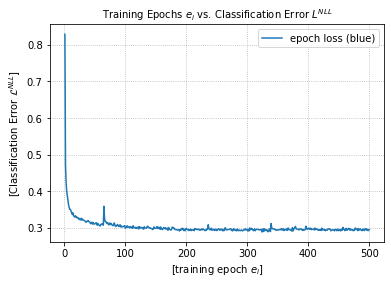

In [27]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

#Load Best model Code

In [28]:
# restore pre-trained model snapshot
best_model_name = "model_epoch_99.pth"

# init pre-trained model class
best_model = MNISTNet()

# load pre-trained models
best_model.load_state_dict(torch.load(os.path.join("models", best_model_name), map_location='cpu'))

<All keys matched successfully>

In [29]:
# set model in evaluation mode
best_model.eval()

MNISTNet(
  (linear1): Linear(in_features=784, out_features=300, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=300, out_features=100, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=100, out_features=50, bias=True)
  (relu3): ReLU(inplace=True)
  (linear4): Linear(in_features=50, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)

In [0]:
eval_dataloader = torch.utils.data.DataLoader(reshaped_eval_dataset, batch_size=10000, shuffle=True)

In [31]:
# init collection of mini-batch losses
eval_mini_batch_losses = []

# iterate over all-mini batches
for i, (images, labels) in enumerate(eval_dataloader):

    # run forward pass through the network
    output = best_model(images)

    # determine classification loss
    loss = nll_loss(output, labels.long())

    # collect mini-batch reconstruction loss
    eval_mini_batch_losses.append(loss.data.item())

# determine mean min-batch loss of epoch
eval_loss = np.mean(eval_mini_batch_losses)

# print epoch loss
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] eval-loss: {}'.format(str(now), str(eval_loss)))

[LOG 20200507-16:25:30] eval-loss: 0.37475350499153137


In [0]:
predictions = torch.argmax(best_model(reshaped_eval_dataset.tensors[0].float()), dim=1)

In [33]:
metrics.accuracy_score(reshaped_eval_dataset.tensors[1], predictions.detach())

0.8635

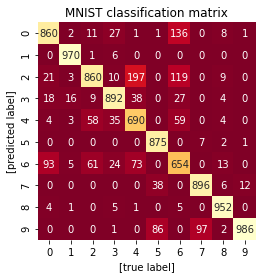

In [34]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(reshaped_eval_dataset.tensors[1], predictions.detach())

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=range(0,10), yticklabels=range(0,10))
plt.title('MNIST classification matrix')
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

In [0]:
# restore pre-trained model snapshot
best_model_numbers = list(range(0,num_epochs,10))

test_results = []

for best_model_number in best_model_numbers:

  temp_results = [best_model_number]

  # init pre-trained model class
  best_model = MNISTNet()

  # load pre-trained models
  best_model.load_state_dict(torch.load(os.path.join("models", "model_epoch_{}.pth".format(best_model_number)), map_location='cpu'))

  # init collection of mini-batch losses
  eval_mini_batch_losses = []

  # iterate over all-mini batches
  for i, (images, labels) in enumerate(eval_dataloader):

      # run forward pass through the network
      output = best_model(images)

      # determine classification loss
      loss = nll_loss(output, labels.long())

      # collect mini-batch reconstruction loss
      eval_mini_batch_losses.append(loss.data.item())

  # determine mean min-batch loss of epoch
  eval_loss = np.mean(eval_mini_batch_losses)

  temp_results.append(eval_loss)

  predictions = torch.argmax(best_model(reshaped_eval_dataset.tensors[0].float()), dim=1)

  temp_results.append(metrics.accuracy_score(reshaped_eval_dataset.tensors[1], predictions.detach()))

  test_results.append(temp_results)
  

In [36]:
test_results

[[0, 0.5770891308784485, 0.7916],
 [10, 0.41147246956825256, 0.8518],
 [20, 0.3678545355796814, 0.8678],
 [30, 0.3540913760662079, 0.8752],
 [40, 0.3712242543697357, 0.8678],
 [50, 0.3961523175239563, 0.8552],
 [60, 0.38536280393600464, 0.8642],
 [70, 0.37262850999832153, 0.8637],
 [80, 0.3590761125087738, 0.8709],
 [90, 0.43498754501342773, 0.8469],
 [100, 0.3616623878479004, 0.87],
 [110, 0.3815629780292511, 0.8609],
 [120, 0.4010545313358307, 0.8552],
 [130, 0.36693891882896423, 0.8677],
 [140, 0.41702020168304443, 0.8486],
 [150, 0.3613818883895874, 0.8698],
 [160, 0.3634476661682129, 0.8676],
 [170, 0.3977048695087433, 0.8515],
 [180, 0.4923427104949951, 0.8324],
 [190, 0.5877193212509155, 0.7959],
 [200, 0.37445059418678284, 0.8657],
 [210, 0.34971463680267334, 0.8759],
 [220, 0.36346131563186646, 0.8734],
 [230, 0.35061854124069214, 0.8763],
 [240, 0.34545600414276123, 0.8805],
 [250, 0.3767450749874115, 0.8683],
 [260, 0.35420480370521545, 0.8788],
 [270, 0.3548858165740967, 0.

Add regularization <br>
Try different optimization algorithm
- L-BFGS
- Conjugate gradient<br>
Try Cross-entropy loss function
Try Leaky Relu
Look into dropout layer for regularization